In [34]:
%load_ext autoreload
%autoreload 2

import dotenv
import os

dotenv.load_dotenv(dotenv_path="secrets.env")
hf_token = os.getenv("HUGGINGFACE_API_KEY")

import os

from transformers import AutoModelForCausalLM, AutoTokenizer
from peft import PeftModel
import dotenv

from tasks.hp.HPTask import HPTriviaTask, HPVerbatimTask, HPVerbatimTaskTranchedByBook
from tasks.hp.HPSAQ import HPSAQ, HPSAQTranchedByBook
from tasks.hp.HPFamiliarity import HPCompletionsFamiliarity, HPFamiliarityTranchedByBook

from datetime import datetime

import tqdm
import torch

import matplotlib.pyplot as plt

plt.style.use('plot_style.txt')

pallet = ["#000000", "#E69F00", "#56B4E9", "#009E73", "#F0E442", "#0072B2", "#D55E00", "#CC79A7"]

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [35]:
def load_ckpt(base_model, folder, ckpt):
    peft_model = PeftModel.from_pretrained(base_model, os.path.join(folder, "checkpoint-" + str(ckpt)))
    return peft_model

In [36]:
books_to_test_on = [1, 2, 3]

# merge the files "tasks/hp/data/tranched_by_book/book_{book_num}.jsonl" into "tasks/hp/data/tranched_by_book/all.jsonl"

all_data = ""
for book_num in books_to_test_on:
    with open(f"tasks/hp/data/tranched_by_book/book_{book_num}.jsonl", "r") as f:
        all_data += f.read()

with open(f"tasks/hp/data/tranched_by_book/all.jsonl", "w") as f:
    f.write(all_data)

In [37]:
tokenizer = AutoTokenizer.from_pretrained(
    "microsoft/Llama2-7b-WhoIsHarryPotter",
    use_auth_token=hf_token
)

tokenizer.pad_token = tokenizer.eos_token

print(tokenizer.pad_token)

hp_familiarity_tasks = [HPFamiliarityTranchedByBook(i) for i in books_to_test_on]

hp_verbatim_task = HPVerbatimTaskTranchedByBook(8, tokenizer, books_to_test_on)

def eval_model(model):
    # hp_familiarity_task = HPCompletionsFamiliarity(dataset_path='tasks/hp/data/msr_data/evaluation_prompts.json')
    # exp_time = datetime.now().strftime("%a-%b%-d-%H%M")
    # hp_familiarity_task.generate_responses(model, tokenizer, eval_onthe_fly=True, eval_model='gpt-3.5-turbo', max_new_tokens=20, temperature=0, verbose=True, n_questions=50)
    # familiarity, responses = hp_familiarity_task.get_accuracies()
    # print(responses)
    # return familiarity

    # accs = {"zero_shot": 0, "few_shot": 0, "unrelated_few_shot": 0}
    # for task in hp_saq_tasks:
    #     task.generate_responses(model, tokenizer, n_questions=10)
    #     this_accs = task.get_accuracies()
    #     accs["zero_shot"] += this_accs["zero_shot"]
    #     accs["few_shot"] += this_accs["few_shot"]
    #     accs["unrelated_few_shot"] += this_accs["unrelated_few_shot"]
    
    # accs["zero_shot"] /= len(hp_saq_tasks)
    # accs["few_shot"] /= len(hp_saq_tasks)
    # accs["unrelated_few_shot"] /= len(hp_saq_tasks)

    # return accs

    # score = 0
    # for task in hp_familiarity_tasks:
    #     task.generate_responses(model, tokenizer, eval_model='gpt-4')
    #     familiarity, responses = task.get_accuracies()
    #     score += familiarity
    #     print(responses)
    # score /= len(hp_familiarity_tasks)

    # return score

    #return hp_verbatim_task.get_test_loss(model).item()

    acc = hp_verbatim_task.get_test_loss(model, n_iters=1000).item()
    print(acc)
    return acc

/root/hp-unlrn/.env/lib/python3.10/site-packages/transformers/models/auto/tokenization_auto.py:711: FutureWarning: The `use_auth_token` argument is deprecated and will be removed in v5 of Transformers. Please use `token` instead.
  warnings.warn(
/root/hp-unlrn/.env/lib/python3.10/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


</s>


In [38]:
# model_ckpts = [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]
# model_folders = ["verbatim_finetune", "verbatim_finetune_base"]

# base_models = ["hp-unlrn", "llama"]

# llama_model = AutoModelForCausalLM.from_pretrained(
#     "meta-llama/Llama-2-7b-chat-hf",
#     use_auth_token=hf_token,
#     torch_dtype=torch.bfloat16
# ).cuda()

# base_acc = eval_model(llama_model)

# del llama_model

# hp_model = AutoModelForCausalLM.from_pretrained(
#     "microsoft/Llama2-7b-WhoIsHarryPotter",
#     use_auth_token=hf_token,
#     torch_dtype=torch.bfloat16
# ).cuda()

# tokenizer.pad_token = tokenizer.eos_token

# hp_acc = eval_model(hp_model)

# del hp_model

# all_accuracies = []

# for model_folder, base_model in zip(model_folders, base_models):
#     if base_model == "llama":
#         accuracies = [(0, base_acc)]

#         base_model = AutoModelForCausalLM.from_pretrained(
#             "meta-llama/Llama-2-7b-chat-hf",
#             use_auth_token=hf_token,
#             torch_dtype=torch.bfloat16
#         ).cuda()
#     else:
#         accuracies = [(0, hp_acc)]

#         base_model = AutoModelForCausalLM.from_pretrained(
#             "microsoft/Llama2-7b-WhoIsHarryPotter",
#             use_auth_token=hf_token,
#             torch_dtype=torch.bfloat16
#         ).cuda()
    
#     for ckpt in model_ckpts:
#         print(ckpt)
#         adapter = load_ckpt(base_model, model_folder, ckpt)
#         acc = eval_model(base_model)
#         accuracies.append((ckpt, acc))
#         adapter.unload()
    
#     all_accuracies.append(accuracies)

#     del base_model

# print(base_acc)
# print(hp_acc)
# print(all_accuracies)

In [39]:
# print("base_acc =", base_acc)
# print("hp_acc =", hp_acc)
# print("all_accuracies =", all_accuracies)

In [40]:
# results for finetuned unlearned and chat models - FOR PAPER
base_acc = 3.036888837814331
hp_acc = 3.4972031116485596
all_accuracies = [[(0, 3.4972031116485596), (100, 3.28092622756958), (200, 3.0460121631622314), (300, 2.9241957664489746), (400, 2.8950257301330566), (500, 2.885110378265381), (600, 2.8738954067230225), (700, 2.8775532245635986), (800, 2.8754568099975586), (900, 2.8759214878082275), (1000, 2.8729376792907715)], [(0, 3.036888837814331), (100, 2.908545970916748), (200, 2.792257070541382), (300, 2.7728617191314697), (400, 2.762115955352783), (500, 2.7416458129882812), (600, 2.7486376762390137), (700, 2.746772050857544), (800, 2.7435569763183594), (900, 2.751146078109741), (1000, 2.750664472579956)]]

In [41]:
# results from prev run
base_acc_ = 0.46534305908678647
hp_acc_ = 0.32427038263675156
all_accuracies_ = [[(0, 0.32427038263675156), (100, 0.32125954361627784), (200, 0.35320556782193674), (300, 0.3950250996178836), (400, 0.3963737045958042), (500, 0.42296944927665525), (600, 0.49241389372109967), (700, 0.44076731789999557), (800, 0.5259048314673566), (900, 0.4175018492498922), (1000, 0.41718241223961816)]]

In [42]:
base_acc_ = 0.22818220519369947
hp_acc_ = 0.10280970625798212
all_accuracies_ = [[(0, 0.10280970625798212), (100, 0.1336739037888463), (200, 0.09450830140485313), (300, 0.24244359301830565), (400, 0.2220093656875266), (500, 0.15197956577266922), (600, 0.18284376330353344), (700, 0.13154533844189017), (800, 0.09663686675180927), (900, 0.1911451681566624), (1000, 0.12537249893571734)]]

In [43]:
# results on cross-entropy eval (1000 samples from books 4-7)
base_acc_ = 3.0362651348114014
hp_acc_ = 3.502548933029175
all_accuracies_ = [[(0, 3.502548933029175), (100, 3.2807469367980957), (200, 3.0449798107147217), (300, 2.9233744144439697), (400, 2.895801305770874), (500, 2.881465196609497), (600, 2.87931227684021), (700, 2.8763437271118164), (800, 2.8760416507720947), (900, 2.872117757797241), (1000, 2.8754565715789795)]]

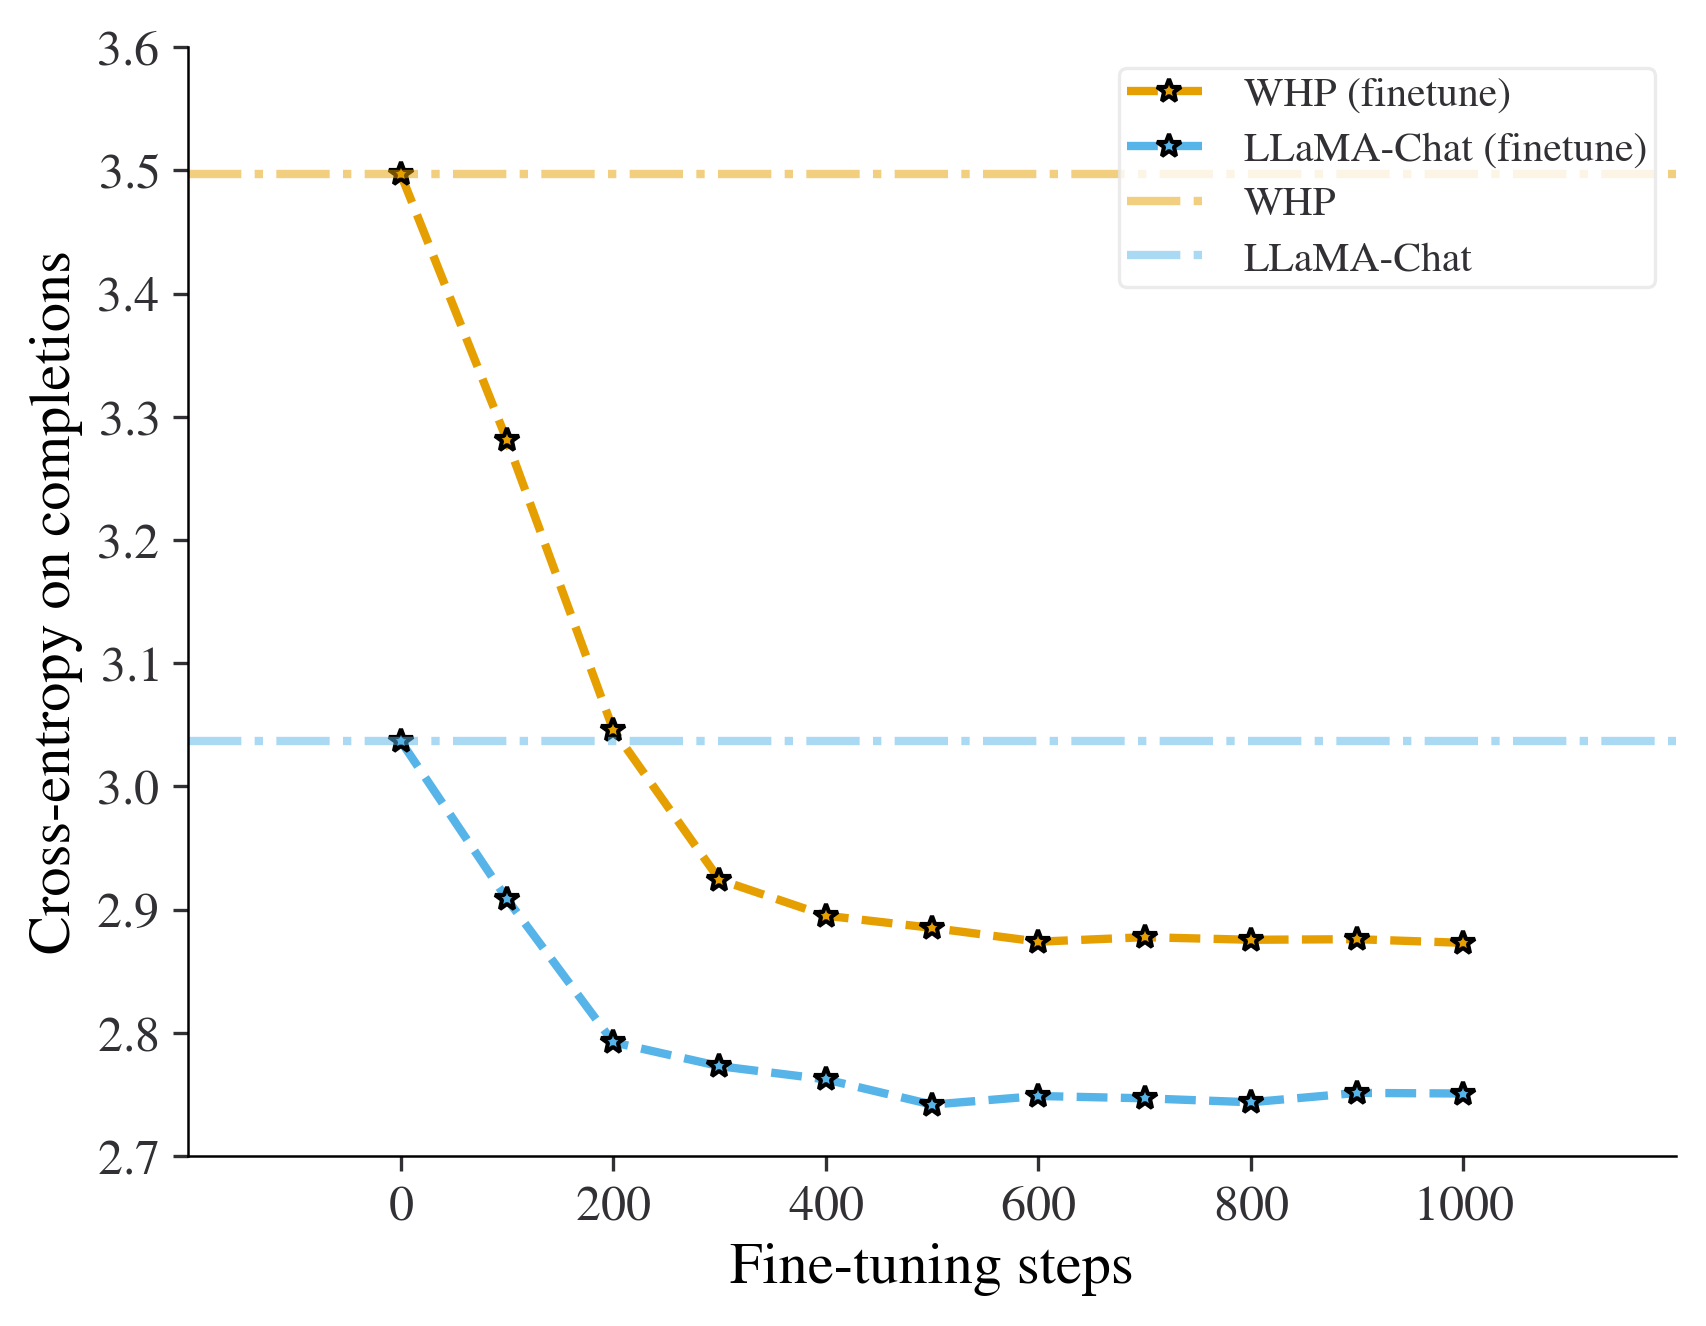

In [44]:
keys = ["zero_shot"]
line_styles = ['--', '-', '-.']

#for y, key in zip(ys, keys):
#    plt.plot(x, y, linestyle="--", marker="*", label="dpo_" + key)

labels = ["WHP (finetune)", "LLaMA-Chat (finetune)"]
colors = [pallet[1], pallet[2]]

for accs, label, color in zip(all_accuracies, labels, colors):
    xs = [ckpt for ckpt, _ in accs]
    ys = [acc for _, acc in accs]
    plt.plot(xs, ys, linestyle="--", marker="*", label=label, color=color)

plt.xlabel('Fine-tuning steps', fontsize=16)
plt.ylabel('Cross-entropy on completions', fontsize=16)

#for key, line_style in zip(keys, line_styles):
#    plt.axhline(y=base_acc[key], color='r', linestyle=line_style, label="base_" + key)
#    plt.axhline(y=hp_acc[key], color='g', linestyle=line_style, label="unlearned_" + key)

plt.axhline(y=hp_acc, linestyle='-.', label="WHP", alpha=0.5, color=colors[0])
plt.axhline(y=base_acc, linestyle='-.', label="LLaMA-Chat", alpha=0.5, color=colors[1])

plt.legend(loc="upper right")

plt.xticks(ticks=[0, 200, 400, 600, 800, 1000])

plt.savefig("ft_comparison.svg", format="svg")

In [45]:
# hp_model = AutoModelForCausalLM.from_pretrained(
#     "microsoft/Llama2-7b-WhoIsHarryPotter",
#     use_auth_token=hf_token,
#     torch_dtype=torch.bfloat16
# ).cuda()

In [46]:
# few_shot_counts = [10, 8, 6, 4, 2, 0]

# unlearned_model_points = []

# for count in few_shot_counts:
#     with torch.no_grad(), torch.autocast(device_type="cuda"):
#         hp_verbatim_task = HPVerbatimTaskTranchedByBook(16, tokenizer, books_to_test_on, few_shot_num=count, few_shot_book_ids=[1, 2, 3])
#         acc = hp_verbatim_task.get_test_loss(hp_model, n_iters=500).item()
#         print(f"few_shot_count={count}, acc={acc}")
#         unlearned_model_points.append((count, acc))

In [47]:
# del hp_model

# llama_model = AutoModelForCausalLM.from_pretrained(
#     "meta-llama/Llama-2-7b-chat-hf",
#     use_auth_token=hf_token,
#     torch_dtype=torch.bfloat16
# ).cuda()

In [48]:
# llama_model_points = []

# for count in few_shot_counts:
#     with torch.no_grad(), torch.autocast(device_type="cuda"):
#         hp_verbatim_task = HPVerbatimTaskTranchedByBook(16, tokenizer, books_to_test_on, few_shot_num=count, few_shot_book_ids=[1, 2, 3])
#         acc = hp_verbatim_task.get_test_loss(hp_model, n_iters=100).item()
#         print(f"few_shot_count={count}, acc={acc}")
#         llama_model_points.append((count, acc))

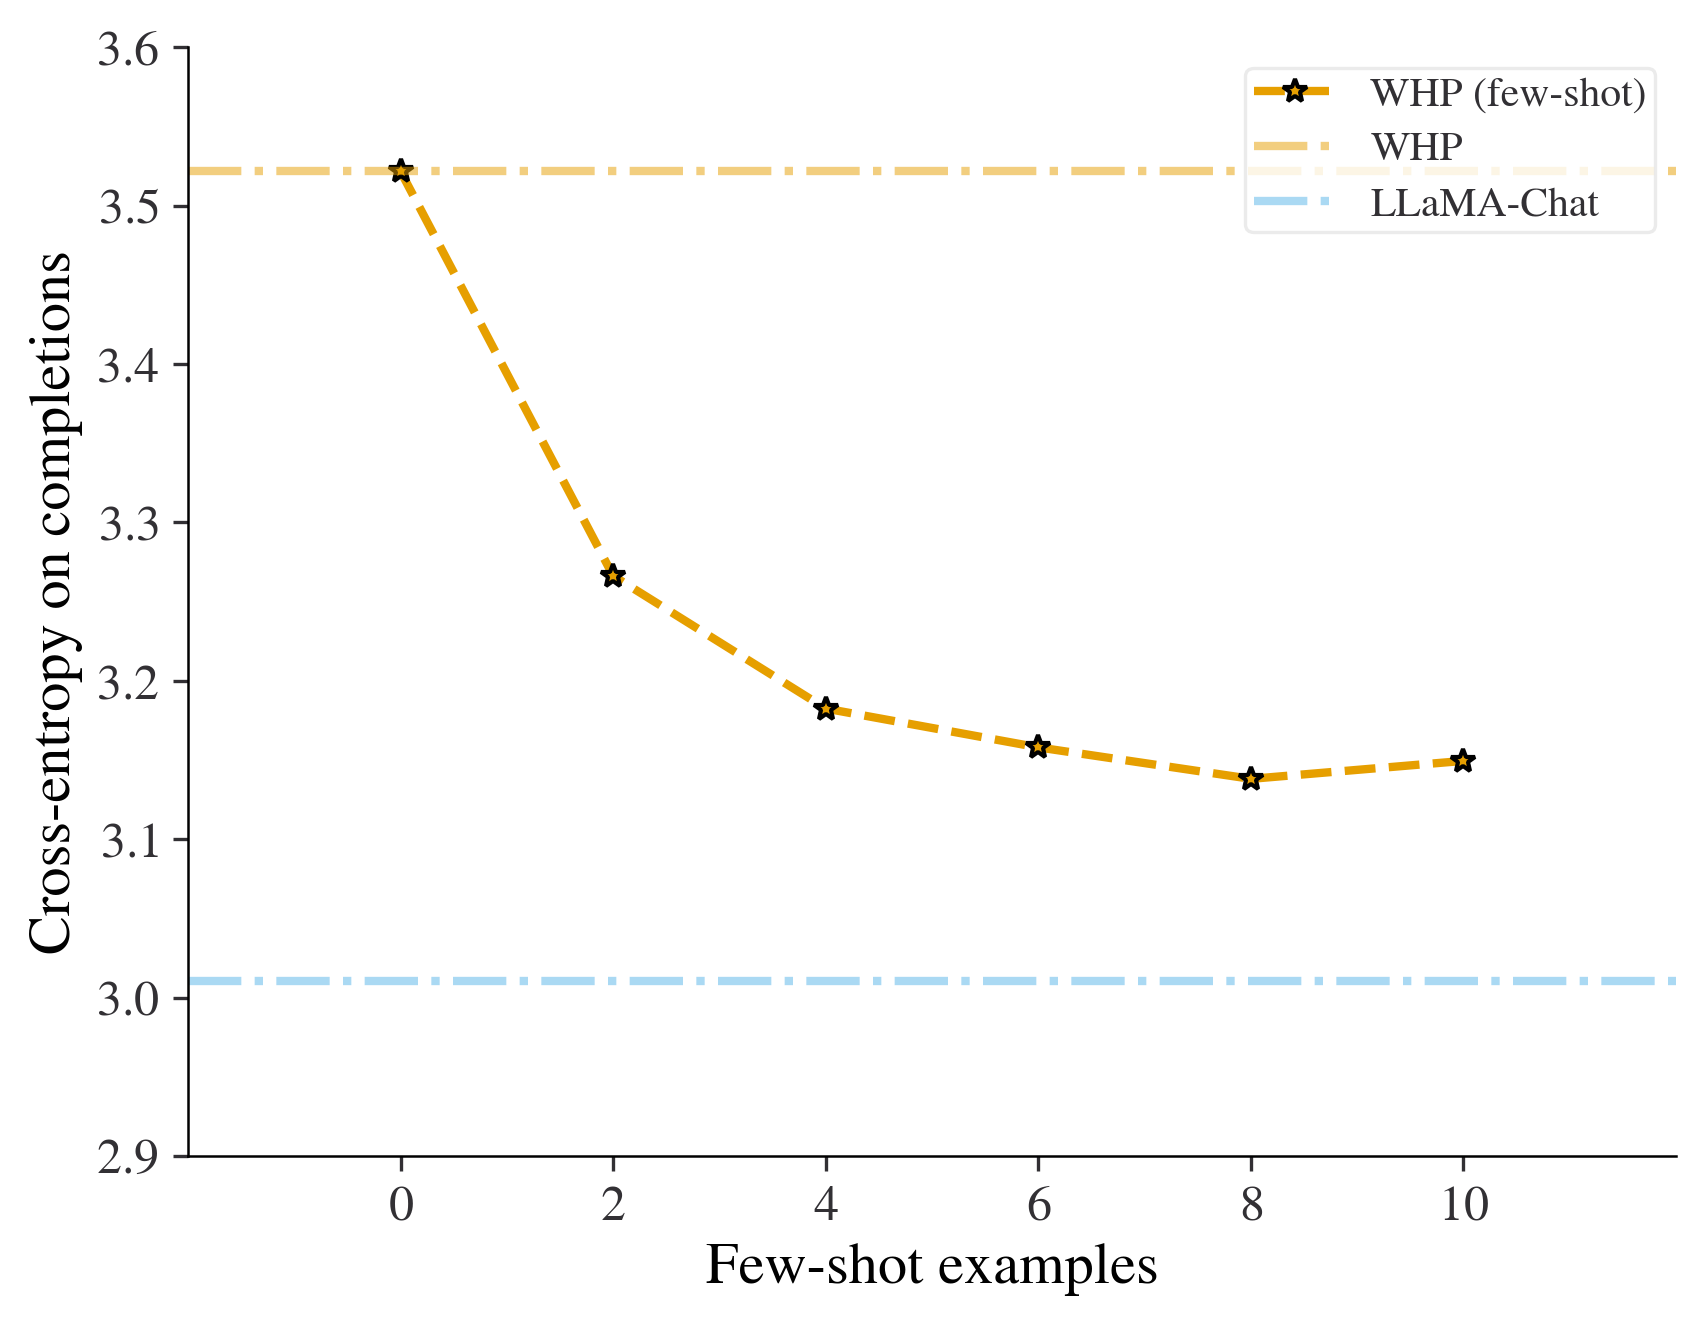

In [49]:
import pandas as pd

# Load the first CSV file
df1 = pd.read_csv('icl_data_results.csv')
x1 = df1['x']
y1 = df1['y']

# Load the second CSV file
df2 = pd.read_csv('icl_data_results_llama.csv')
x2 = df2['x']
y2 = df2['y']

# Plot the data
plt.plot(x1, y1, label='WHP (few-shot)', linestyle='--', marker='*', color=colors[0])
# plt.plot(x2, y2, label='LLaMA-Chat', linestyle='--', marker='*')

plt.axhline(y=y1[len(y1)-1], linestyle='-.', label="WHP", color=colors[0], alpha=0.5)
plt.axhline(y=y2[len(y2)-1], linestyle='-.', label="LLaMA-Chat", color=colors[1], alpha=0.5)

# Add labels and legend
plt.xlabel('Few-shot examples', fontsize=16)
plt.ylabel('Cross-entropy on completions', fontsize=16)
plt.legend(loc="upper right")

plt.xticks(ticks=[0, 2, 4, 6, 8, 10])

# Show the plot
plt.savefig("icrl.svg", format="svg")
